# FUSE 2024, Newcastle University: Machine learning molecular dynamics for battery materials

This notebook is a small preview of the research work proposed for the 'Machine learning molecular dynamics for battery materials' FUSE2024 internship. The project will extend the work presented in this [recent paper](https://doi.org/10.1021/acs.macromol.0c02132). We will use modern Machine Learning techniques to automatically identify solvation structure and dynamics of ions in electrolytes and improve our theoretical understanding of ion transport.

## Part I: Warm-up, manipulating atomic trajectories

Let us start by loading one of the [published](https://doi.org/10.1021/acs.macromol.0c02132) Molecular Dynamics (MD) trajectories. We will use the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) package to manage atoms, molecules and trajectories.

In [1]:
from ase.io import read, write
traj = read('data/trajectory.xyz', ':')

In [2]:
from ase.io import read
import nglview as ng

traj = read('data/trajectory.xyz', ':')
view = ng.show_asetraj(traj)
view.add_representation(repr_type='unitcell')
view._set_size(w='100%', h='600px')
view

NGLWidget(max_frame=449)

`Traj` is a list of `Atoms` objects. Each `Atoms` instance comprises all atomic positions, chemical elements etc for a given atomic configuration/snapshot (e.g. at time $t=0$). Let's check these values for the first configuration.

In [3]:
at0 = traj[0].copy()
print(f'The "info" field is a dictionary containing global information relevant to the entire configuration of atoms: {at0.info}')
print(f'Whereas the "arrays" field is a dictionary containing information pertaining to individual atom: {at0.arrays.keys()}')

The "info" field is a dictionary containing global information relevant to the entire configuration of atoms: {'Time': 1.0, 'Traj': 1, 'SEC_label': 1.0}
Whereas the "arrays" field is a dictionary containing information pertaining to individual atom: dict_keys(['numbers', 'positions'])


**Exercise I**: ASE is a versatile package (consult the [documentation](https://wiki.fysik.dtu.dk/ase/)). You could get more familiar with its functionality by trying on your own:
- what is the length of the trajectory (how many total atomic snapshots in `Traj`)?
- how many atoms are there in each configuration? is this number constant across the trajectory?
- how many atoms of each chemical element/species? (Hint: uses the `get_chemical_symbols()` method of the `Atoms` object)

Test your code below:

In [4]:
#######################
### Experiment here ###
#######################

You may have noticed there is a single lithium ion $(Li^+)$ diffusing in the surrounding material. We can write a utility function that returns the index of the Li atom within an `Atoms` object (knowing there is a single Li ion).

In [5]:
from ase import Atoms
def get_Li_index(at: Atoms) -> int:
    id = at.get_chemical_symbols().index('Li')
    return id

for i, at in enumerate(traj[:5]):
    print(f'The index of the lithium atom in snapshot {i} is {get_Li_index(at)}')

The index of the lithium atom in snapshot 0 is 4176
The index of the lithium atom in snapshot 1 is 4176
The index of the lithium atom in snapshot 2 is 4176
The index of the lithium atom in snapshot 3 is 4176
The index of the lithium atom in snapshot 4 is 4176


Ions are the workhorse of modern rechargeable batteries. Here, Li ions transport one positive charge through a polymer material via a hopping mechanism: the ion spends most of the time solvated by surrounding molecules/functional groups, and every once in a while it hops to a different solvation environment. The process repeats and the ion gradually diffuses away from the original position. We would like to characterize those solvation environments and understand:
- how many types of solvation environments are there in this material
- how are the environments distributed etc

Let's start by creating a function which takes an atomic configuration/snapshot and returns the atomic environment surrounding the lithium ion

In [6]:
import numpy as np

def sel_atomic_env(at, rcut):
    #input at config is passed by reference, making a copy avoids overwriting
    at_env = at.copy()
    
    #wrap atoms across the periodic boundaries so that the Li atom is the middle of the cell
    Li_id = get_Li_index(at)
    frac_orig = at_env.get_scaled_positions()[Li_id,:]
    at_env.wrap(center=frac_orig)
    
    #translate the middle of the cell to (0,0,0)
    real_orig = at_env.get_positions()[Li_id,:]
    at_env.translate(-real_orig)
    
    #compute all distances from (0,0,0) and delete atoms further than rcut
    r = np.sqrt((at_env.positions**2).sum(1))    
    del at_env[r>rcut]
    at_env.pbc = False
    at_env.cell = None
    
    return at_env

Now we can display the atomic environment within a 6 $\rm\AA$ cutoff around the lithium ion in the first snapshot

In [7]:
rcut = 6.0
at0_env = sel_atomic_env(at0, rcut)

# visualization function with special handling of central lithium
def view_at_anv(at0_env):
    view = ng.show_ase(at0_env)
    view._set_size(w='100%', h='600px')
    view.clear_representations()
    Li_id = get_Li_index(at0_env)
    all_other_atoms = [i for i in range(len(at)) if i != Li_id]
    view.add_representation(repr_type='ball+stick', selection=[Li_id])
    view.add_representation(repr_type='ball+stick', selection=all_other_atoms)
    return view

view_at_anv(at0_env)

NGLWidget()

## Part II: Using Atomic Descriptors to featurize the atomic environments

We have extracted the Li atomic environment from the first trajectory snapshot. Once we eventually process the entire trajectory, we will have 450 independent environments. However, many of these environments are very similar to each other and we would like to classify them into specific types of solvation characterized by their molecular arrangement around the ion. For this task, we will use Atomic Descriptors developed by the [Machine Learning Interatomic Potential (MLIP)](https://arxiv.org/abs/2401.00096) community to fit force fields. These atomic descriptors are ML features which map the atomic neighbourhood of a target atom to higher-dimensional space with special properties: translational, rotational and permutational invariance. Let us explore this concept in a bit more depth.

We will start with a small atomic environment around the Li atom and remove all hydrogen atoms.

In [8]:
env = sel_atomic_env(at0, 3.0)
del env[env.numbers==1] #remove H atoms to simplify the environment
view_at_anv(env)

NGLWidget()

In [9]:
print(f'Number of Li neighbours is: {len(env)-1}')

Number of Li neighbours is: 9


The Li solvation environment is determined by the atoms surrounding the Li: their positions (3D) and their chemical species (1D). In total, this environment is determined by 8x3+8x1=32 numbers (at this cutoff, ignoring H atoms). In other words, we can think of the environment as a vector in 32-dimensional space.

**Exercise II:** How does the dimensionality of this environment vector change with the cutoff value? How can we check that?

In [10]:
#######################
### Experiment here ###
#######################

To compare two different environments, we would need to compare the 32 numbers, for example, we could compute the distance in $\mathbb{R}^{32}$. sIn comparing these environments, the problem is that certain operations like rotation, translation and like-atom permutations change the vector in $\mathbb{R}^{32}$ but the environments remain the same: our environment is not uniquely determined by the vector (there are in fact an infinity of vectors which determine the same environment).
Here is where Atomic Descriptors become very useful:

In [11]:
from mace.calculators import mace_mp
import warnings
warnings.filterwarnings("ignore")

mace = mace_mp()

# compute descriptors for each atom in the environment
desc = mace.get_descriptors(env, num_layers=1)

# keep the descriptors for the Li atom
desc = desc[get_Li_index(env), :]

print(f'Descriptor dimensionality: {desc.shape}')

Using Materials Project MACE for MACECalculator with /Users/imagdau/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Descriptor dimensionality: (128,)


These atomic descriptors have a higher dimensionality than the original vector in $\mathbb{R}^{32}$, in fact for this model specifications (for more detail check [equations 1-10](https://doi.org/10.1063/5.0155322)) they live in $\mathbb{R}^{128}$, so what have we gained? These new vectors are rotationally, translationally and permutationally invariant so they uniquely determine each solvation environment. Let's check that! Here are some translated, rotated and permutationally reordered environments:

In [12]:
print('Original')
print(env.positions)

Original
[[ 1.30186  0.16996 -1.66855]
 [ 0.52108 -1.22342 -1.60123]
 [-1.00491 -1.11352 -1.45901]
 [-0.83115 -0.24222  1.97786]
 [-1.40707  0.86789  1.38266]
 [-0.64457  1.71505  0.58722]
 [-1.32882  2.6032  -0.25682]
 [ 1.84362  0.6863   2.11764]
 [ 0.57577 -0.5466   2.0822 ]
 [ 0.       0.       0.     ]]


In [13]:
print('Translated')
env_trs = env.copy()
env_trs.translate([10,3,2])
print(env_trs.positions)

Translated
[[11.30186  3.16996  0.33145]
 [10.52108  1.77658  0.39877]
 [ 8.99509  1.88648  0.54099]
 [ 9.16885  2.75778  3.97786]
 [ 8.59293  3.86789  3.38266]
 [ 9.35543  4.71505  2.58722]
 [ 8.67118  5.6032   1.74318]
 [11.84362  3.6863   4.11764]
 [10.57577  2.4534   4.0822 ]
 [10.       3.       2.     ]]


In [14]:
print('Rotated')
env_rot = env.copy()
env_rot.rotate(45, (1,1,1))
print(env_rot.positions)

Rotated
[[ 0.15077851  1.31363771 -1.66114622]
 [-0.0106811  -0.22355916 -2.06932974]
 [-1.20089368 -0.9512613  -1.42528502]
 [ 0.40693839 -1.22974261  1.72729421]
 [-0.70244491 -0.44286174  1.98878665]
 [-0.75437146  0.87169035  1.5403811 ]
 [-2.00787043  1.50244368  1.52298675]
 [ 2.34172458  0.82716546  1.47866996]
 [ 1.6864693  -0.79536672  1.22026742]
 [ 0.          0.          0.        ]]


In [15]:
print('Permuted')
order = np.random.permutation(len(env))
env_per = env[order]
print(env_per.positions)

Permuted
[[ 0.57577 -0.5466   2.0822 ]
 [ 0.52108 -1.22342 -1.60123]
 [ 1.84362  0.6863   2.11764]
 [-0.64457  1.71505  0.58722]
 [-0.83115 -0.24222  1.97786]
 [ 0.       0.       0.     ]
 [-1.00491 -1.11352 -1.45901]
 [-1.32882  2.6032  -0.25682]
 [-1.40707  0.86789  1.38266]
 [ 1.30186  0.16996 -1.66855]]


**Exercise III**: Using these examples, how could we check if Atomic Descriptors are invariant to the operations enumerated above?

In [16]:
#######################
### Experiment here ###
#######################

Finding appropriate Atomic Descriptors has become an entire [filed of science](https://doi.org/10.1021/acs.chemrev.1c00022) in its own rights. The MACE descriptors shown here are some of the most smooth, complete and efficient descriptors found so far. Let us now compute the descriptors for the entire trajectory and arrange the data into a single matrix of numbers

In [17]:
from tqdm import tqdm

envs = []
descs  = []

#loop through the entire trajectory
for at in tqdm(traj):
    #find the atommic environment surrounding the Li ion
    env = sel_atomic_env(at, rcut=5.0)
    
    #remove hydrogen atoms to reduce dimensionality
    del env[env.numbers==1] #remove H atoms
    envs.append(env)
    
    #isolate the descriptors corresponding to the Li atom
    idx = get_Li_index(env)
    
    #add the new vector to the list of descriptors
    descs.append(
        mace.get_descriptors(env, num_layers=1)[idx,:]
    )

#transform the list of vectors into a matrix and normalize each line
descs = np.vstack(descs)
descs /= np.linalg.norm(descs, axis=1)[:, np.newaxis]

  0%|          | 0/450 [00:00<?, ?it/s]

100%|██████████| 450/450 [01:26<00:00,  5.20it/s]


## Part III: 

We now have our 450 solvation environments encoded in a high-dimensional space:

In [18]:
print(f'Dimensionality of the data is: {descs.shape}')

Dimensionality of the data is: (450, 128)


It would be great to visualize this feature space and check which solvation environments are similar to each other. In other words, check which points cluster together. [Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) techniques can be used to project our $\mathbb{R}^{128} feature space into e.g. 2D, where we can easily visualize it. One popular dimensionality reduction technique is [UMAP](https://umap-learn.readthedocs.io/en/latest/):

In [134]:
from umap import UMAP

reducer = UMAP(n_neighbors=100, min_dist=0.01, n_components=2, random_state=42)
descs_reduced = reducer.fit_transform(descs)

print(f'This transformer reduces our original data from {descs.shape} to {descs_reduced.shape}')

This transformer reduces our original data from (450, 128) to (450, 2)


Now we can visualize this data projection (which is designed to maintain the clustering structure):

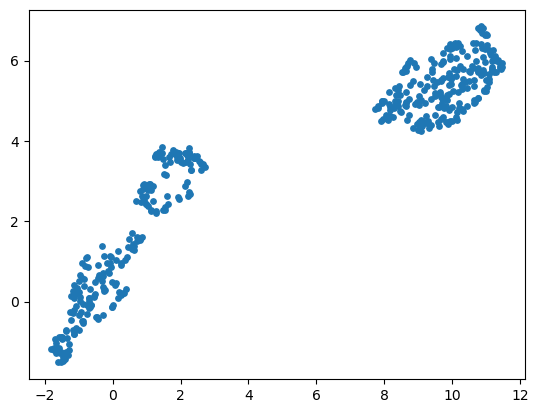

In [135]:
from matplotlib import pyplot as plt

plt.scatter(descs_reduced[:,0], descs_reduced[:,1], s=15)

This projection suggests there are three classes of solvation environments. Within each class, environments are similar to each-other. We can use clustering techniques to automatically assign each data point to a class (the [ward metric](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html) is a popular option):

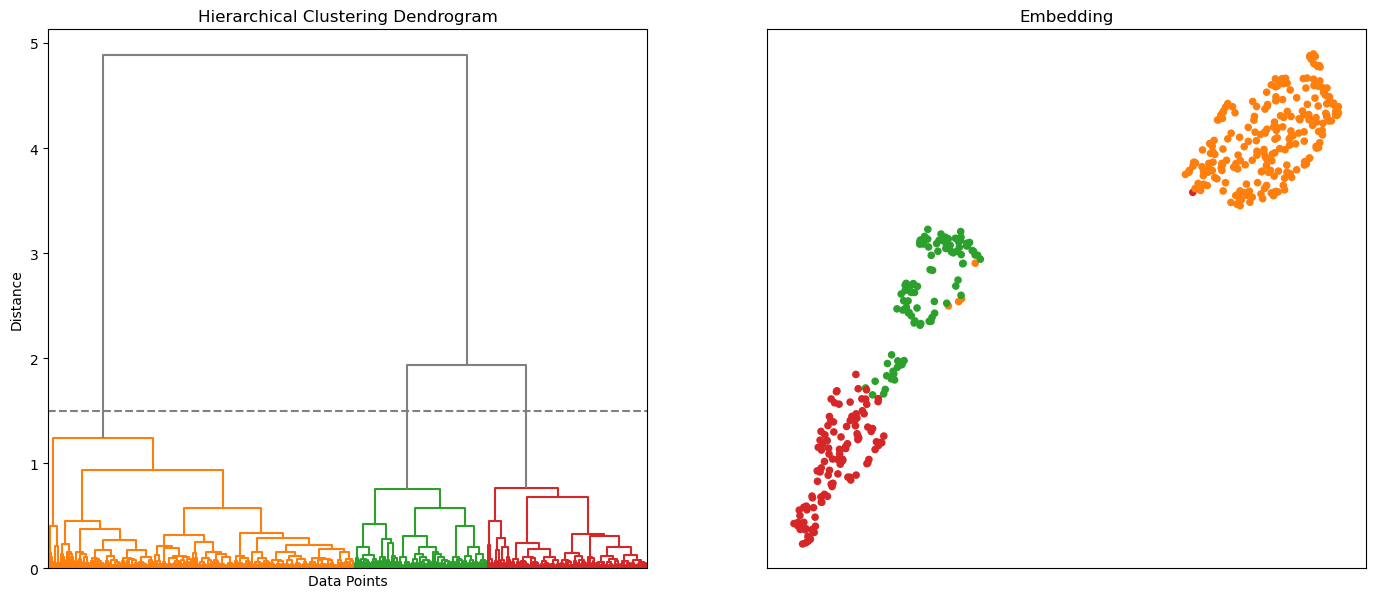

In [136]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 7))

threshold = 1.5
linkage_matrix = linkage(descs, method='ward')
plt.subplot(1,2,1)
R = dendrogram(linkage_matrix, color_threshold=threshold, no_labels=True, above_threshold_color='gray')
plt.axhline(y=threshold, color='gray', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')

#sort the colors according to the original order of the data points
_, cols = zip(*sorted(zip(R['leaves'], R['leaves_color_list'])))

plt.subplot(1,2,2)
plt.scatter(descs_reduced[:,0], descs_reduced[:,1], c=cols, s=20)
plt.xticks([])
plt.yticks([])
plt.title('Embedding')
plt.show()

**Exercise IV:** How can we understand this [denrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html). What happens if we adjust the `threshold` level? What is this `threshold`?

In [22]:
#######################
### Experiment here ###
#######################

**Exercise V:** How does this result compare with the original paper? The original labels are stored in **env.info['SEC_label']** (-1 represent environments which could not be placed in any category).

In [23]:
#######################
### Experiment here ###
#######################